In [2]:
# Cell 1 — Title & quick notes (Markdown)
"""
AI Health Diagnostic — Phase 1
Task: Build a baseline Chest X-ray classifier (Normal vs Pneumonia)
Notes: Run small batch first to check pipeline. Save model to backend/models/xray_model.h5
"""


'\nAI Health Diagnostic — Phase 1\nTask: Build a baseline Chest X-ray classifier (Normal vs Pneumonia)\nNotes: Run small batch first to check pipeline. Save model to backend/models/xray_model.h5\n'

In [3]:
# Cell 2 — Imports & config
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Config
IMAGE_SIZE = (224, 224)   # good for transfer learning later
BATCH_SIZE = 16
EPOCHS = 8                # small for initial test, increase later
SEED = 42

DATA_DIR = "../data/raw"  # adjust if notebook path differs
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
TEST_DIR = os.path.join(DATA_DIR, "test")

OUTPUT_MODEL_PATH = "../backend/models/xray_model.h5"


In [4]:
# Cell 3 — Quick check: list classes and sample counts
def count_images(folder):
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            print(cls, len(os.listdir(cls_path)))

print("Train folder counts:")
count_images(TRAIN_DIR)
print("\nVal folder counts:")
count_images(VAL_DIR)
print("\nTest folder counts:")
count_images(TEST_DIR)


Train folder counts:
NORMAL 9732
PNEUMONIA 9990

Val folder counts:
NORMAL 3656
PNEUMONIA 3935

Test folder counts:
NORMAL 1944
PNEUMONIA 2097


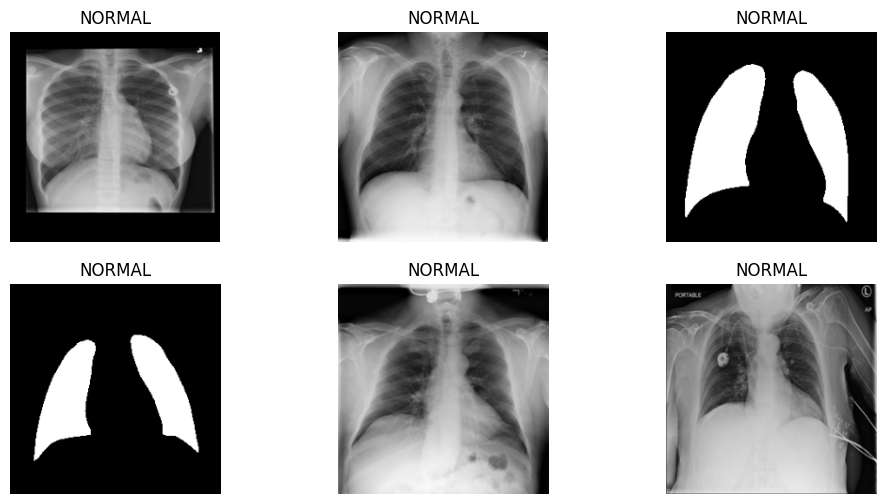

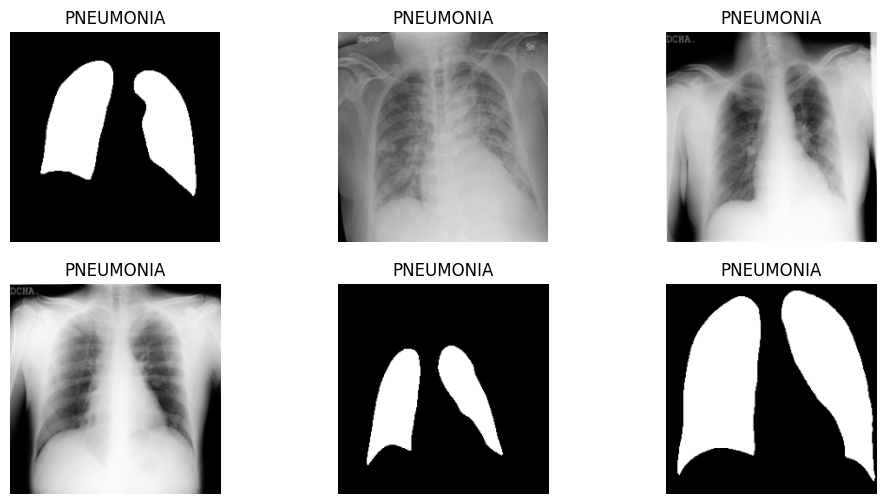

In [5]:
# Cell 4 — Visualize sample images
import cv2
def show_samples(folder, cls, n=6):
    cls_path = os.path.join(folder, cls)
    files = os.listdir(cls_path)[:n]
    plt.figure(figsize=(12,6))
    for i,f in enumerate(files):
        img = cv2.imread(os.path.join(cls_path, f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMAGE_SIZE)
        plt.subplot(2, n//2, i+1)
        plt.imshow(img); plt.title(cls); plt.axis('off')
    plt.show()

show_samples(TRAIN_DIR, 'NORMAL', n=6)
show_samples(TRAIN_DIR, 'PNEUMONIA', n=6)


In [6]:
# Cell 5 — Data generators (augment training slightly)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMAGE_SIZE, color_mode='rgb',
    batch_size=BATCH_SIZE, class_mode='binary', shuffle=True, seed=SEED
)

val_gen = test_val_datagen.flow_from_directory(
    VAL_DIR, target_size=IMAGE_SIZE, color_mode='rgb',
    batch_size=BATCH_SIZE, class_mode='binary', shuffle=False, seed=SEED
)
test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMAGE_SIZE, color_mode='rgb',
    batch_size=1, class_mode='binary', shuffle=False
)


Found 19722 images belonging to 2 classes.
Found 7591 images belonging to 2 classes.
Found 4041 images belonging to 2 classes.


In [7]:
def build_baseline(input_shape=(*IMAGE_SIZE, 3)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

model = build_baseline()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                        

In [8]:
# Cell 7 — Compile + callbacks
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(OUTPUT_MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]


In [9]:
# Cell 8 — Optional: compute class weights if imbalance (recommended)
from collections import Counter
train_classes = train_gen.classes  # requires TF >= 2.x
counter = Counter(train_classes)
print(counter)   # {0: N_normal, 1: N_pneumonia}
total = sum(counter.values())
class_weight = {k: total/(len(counter)*v) for k,v in counter.items()}
print("class_weight:", class_weight)


Counter({1: 9990, 0: 9732})
class_weight: {0: 1.0132552404438964, 1: 0.987087087087087}


In [10]:
# Cell 9 — Train (small run to validate pipeline)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs= EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight  # optional
)


Epoch 1/8
1233/1233 [==============================] - ETA: 0s - loss: 1.8942 - accuracy: 0.6051
Epoch 1: val_accuracy improved from -inf to 0.66078, saving model to ../backend/models\xray_model.h5
1233/1233 [==============================] - 1210s 979ms/step - loss: 1.8942 - accuracy: 0.6051 - val_loss: 0.6599 - val_accuracy: 0.6608 - lr: 0.0010
Epoch 2/8
1233/1233 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.6192
Epoch 2: val_accuracy did not improve from 0.66078
1233/1233 [==============================] - 1198s 971ms/step - loss: 0.6613 - accuracy: 0.6192 - val_loss: 0.7546 - val_accuracy: 0.5105 - lr: 0.0010
Epoch 3/8
1233/1233 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.6244
Epoch 3: val_accuracy did not improve from 0.66078
1233/1233 [==============================] - 1193s 968ms/step - loss: 0.6364 - accuracy: 0.6244 - val_loss: 0.6115 - val_accuracy: 0.6346 - lr: 0.0010
Epoch 4/8
1233/1233 [==============================] 

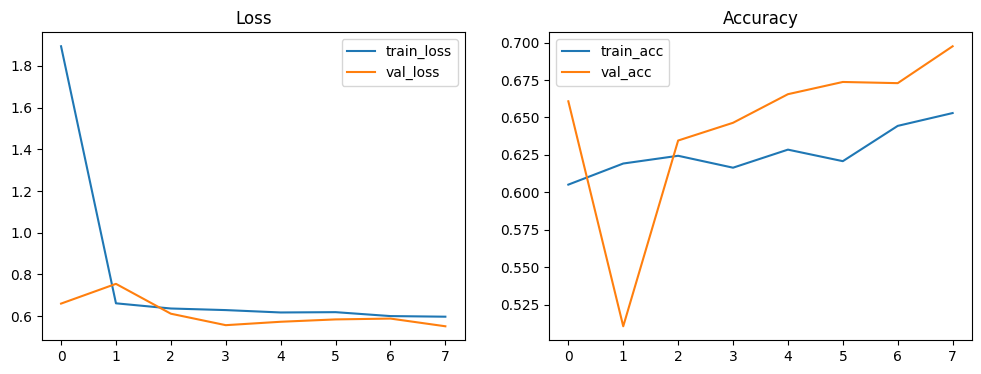

In [11]:
# Cell 10 — Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()



4041/4041 [==============================] - 138s 34ms/step
              precision    recall  f1-score   support

           0       0.63      0.92      0.75      1944
           1       0.87      0.51      0.64      2097

    accuracy                           0.70      4041
   macro avg       0.75      0.71      0.69      4041
weighted avg       0.75      0.70      0.69      4041



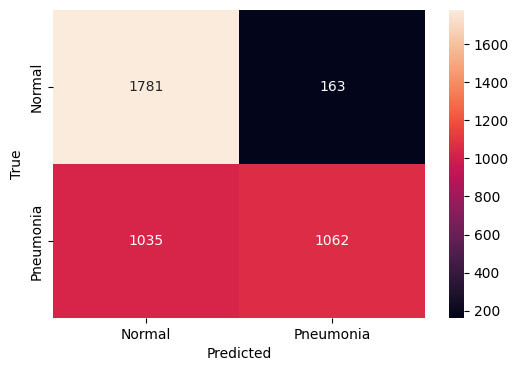

In [12]:
# Cell 11 — Evaluate on test set and show confusion matrix & classification report
# Build predictions on test set
test_steps = test_gen.n  # since batch_size=1
preds = model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = (preds.ravel() > 0.5).astype(int)
y_true = test_gen.classes

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Normal','Pneumonia'], yticklabels=['Normal','Pneumonia'])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


In [13]:
# Cell 12 — Save final model (already saved by checkpoint) and example inference function
from tensorflow.keras.models import load_model
model = load_model(OUTPUT_MODEL_PATH)

def predict_image(img_path, model, target_size=IMAGE_SIZE):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    arr = img.astype('float32')/255.0
    arr = np.expand_dims(arr, axis=0)
    p = model.predict(arr)[0][0]
    return p

# Example:
# print(predict_image('../data/raw/test/PNEUMONIA/somefile.png', model))
